In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy as sp

from datetime import datetime, timedelta
import random

In [2]:
def plot_global_impressions_overlay(data, ax):
    ax.margins(x=0)
    clicks_by_time = data.groupby('ts')['recs'].sum()
    time_values = pd.date_range(data.ts.min(), data.ts.max(), freq='T')
    clicks_by_time = clicks_by_time.reindex(time_values, fill_value=0)
    ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              clicks_by_time.values[np.newaxis],
              cmap='RdYlGn', alpha=0.3)

def plot_versus_time(time, data, y_label):
    # Create the plot
    fig, ax = plt.subplots()
    ax.plot(time, data)

    # Add labels and title to the plot
    ax.set_xlabel('Time')
    ax.set_ylabel(y_label)

    # Format the x-axis labels to prevent overlapping
    date_fmt = mdates.DateFormatter('%d/%m %H:%M')
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(date_fmt)
    fig.autofmt_xdate(rotation=30)
    
    return ax
    
def limited_data(df, min_date, max_date):
    return df[(df['ts'] > min_date) & (df['ts'] <= max_date)]

In [3]:
df = pd.read_csv('../data/bq-results-20230430-224438-1682894867633.csv')
df['ts'] = pd.to_datetime(df['ts']) + timedelta(hours=2)
df = df.dropna()
df

,froomle_item_id,ts,clicks,recs
0,4104476,2023-04-26 04:18:00+00:00,0,1
1,4104476,2023-04-26 04:20:00+00:00,0,5
2,4104476,2023-04-26 04:21:00+00:00,0,1
3,4104476,2023-04-26 06:42:00+00:00,0,1
4,4104476,2023-04-26 06:44:00+00:00,0,4
...,...,...,...,...
72269,8022354,2023-05-01 00:40:00+00:00,0,1
72270,8022354,2023-05-01 00:41:00+00:00,0,3
72271,8022354,2023-05-01 00:42:00+00:00,0,5
72272,8022354,2023-05-01 00:43:00+00:00,0,3


In [4]:
df.recs.sum()

1122004

In [5]:
limited_data(df, '2023-04-26 06:00', '2023-04-27 00:00').recs.sum()

255739

In [2]:
255739 / ((24-6)*60*60*3)

1.3155298353909466

In [7]:
df.clicks.sum() / df.recs.sum()

0.012442914642015537

In [8]:
pd.unique(df.ts.sort_values())

<DatetimeArray>
['2023-04-26 02:00:00+00:00', '2023-04-26 02:01:00+00:00',
 '2023-04-26 02:02:00+00:00', '2023-04-26 02:03:00+00:00',
 '2023-04-26 02:04:00+00:00', '2023-04-26 02:05:00+00:00',
 '2023-04-26 02:06:00+00:00', '2023-04-26 02:07:00+00:00',
 '2023-04-26 02:08:00+00:00', '2023-04-26 02:09:00+00:00',
 ...
 '2023-05-01 00:35:00+00:00', '2023-05-01 00:36:00+00:00',
 '2023-05-01 00:37:00+00:00', '2023-05-01 00:38:00+00:00',
 '2023-05-01 00:39:00+00:00', '2023-05-01 00:40:00+00:00',
 '2023-05-01 00:41:00+00:00', '2023-05-01 00:42:00+00:00',
 '2023-05-01 00:43:00+00:00', '2023-05-01 00:44:00+00:00']
Length: 7055, dtype: datetime64[ns, UTC]

In [9]:
df.value_counts('froomle_item_id')

froomle_item_id
7975997    1265
8002233    1115
8012306    1084
8002058    1042
7988925     907
           ... 
7961801       2
7961516       2
7953262       2
7921562       2
7952491       1
Name: count, Length: 1207, dtype: int64

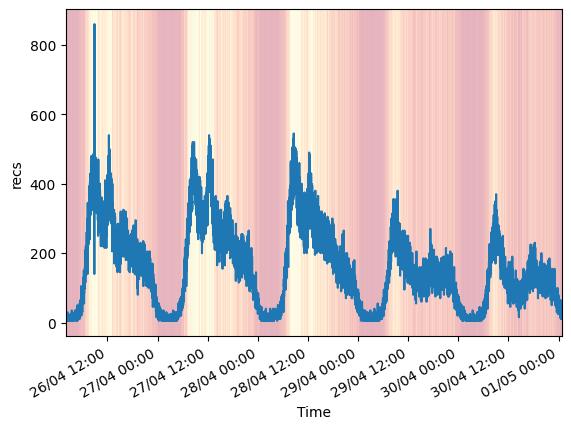

In [10]:
# d = limited_data(df, '2023-04-26 06:00', '2023-04-27 00:00')
d = df
clicks_by_time = d.groupby('ts')['recs'].sum()
ax = plot_versus_time(clicks_by_time.index, clicks_by_time.values, 'recs')
plot_global_impressions_overlay(d, ax)

# clicks_by_time = limited_data(df, '2023-04-26 7:00', '2023-04-26 19:00').groupby('ts')['recs'].sum()
# plot_versus_time(clicks_by_time.index, clicks_by_time.values, 'recs')

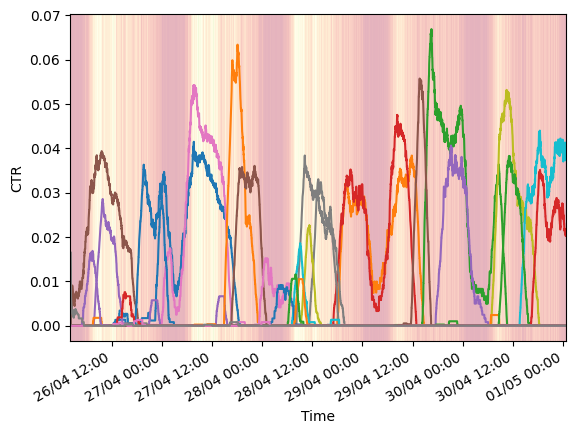

In [12]:
def plot_item(data, item_id):
    item_data = data[data['froomle_item_id'] == item_id]
    
    series = item_data['clicks'] / np.maximum(item_data['recs'], 10)

    series.index = item_data['ts']
    time_values = pd.date_range(df.ts.min(), df.ts.max(), freq='T')
    series = series.reindex(time_values, fill_value=0)

    series = series.rolling("120min").mean()

    return plot_versus_time(series.index, series.values, 'CTR')
    
    
# time = np.arange('2023-04-27', '2023-04-28', timedelta(minutes=1), dtype=np.datetime64)
# data = limited_data(df, '2023-04-27', '2023-04-28')
data = df
items = data.value_counts('froomle_item_id')
ax = None
for i, v in items.items():
    if v < 200:
        break
        
    if ax is None:
        ax = plot_item(data, i)

    else:
        item_data = data[data['froomle_item_id'] == i]
    
        series = item_data['clicks'] / np.maximum(item_data['recs'], 10)

        series.index = item_data['ts']
        time_values = pd.date_range(df.ts.min(), df.ts.max(), freq='T')
        series = series.reindex(time_values, fill_value=0)

        series = series.rolling("120min").mean()
        ax.plot(series.index, series.values)

plot_global_impressions_overlay(data, ax)


## Trying to remove the nightly gaps

In [398]:
item_data = df[df.froomle_item_id == 7975997]
item_data

,froomle_item_id,ts,clicks,recs
19009,7975997,2023-04-26 13:13:00+00:00,0,34
19010,7975997,2023-04-26 13:14:00+00:00,1,55
19011,7975997,2023-04-26 13:15:00+00:00,1,33
19012,7975997,2023-04-26 13:16:00+00:00,0,21
19013,7975997,2023-04-26 13:17:00+00:00,2,23
...,...,...,...,...
20269,7975997,2023-04-29 10:48:00+00:00,0,1
20270,7975997,2023-04-29 10:49:00+00:00,0,18
20271,7975997,2023-04-29 10:50:00+00:00,0,18
20272,7975997,2023-04-29 10:51:00+00:00,0,3


In [402]:
item_data.clicks.sum()/item_data.recs.sum()

0.02985860229203053

In [457]:
pd.unique(df.sort_values('froomle_item_id').froomle_item_id)

array([4104476, 4214438, 5224565, ..., 8022301, 8022333, 8022354])

In [458]:
times = pd.unique(df.sort_values('ts').ts)

In [482]:
expanded_recs = []
for t in times:
    data = df[df.ts == t]
    minute_results = []
    for _, r in data.iterrows():
        item = r.froomle_item_id
        minute_results.extend([(item, 1)] * r.clicks)
        minute_results.extend([(item, 0)] * (r.recs-r.clicks))
    random.shuffle(minute_results)
    expanded_recs.extend(minute_results)

In [524]:
result = []
for i, (item, click) in enumerate(expanded_recs):
    if i % 1000 == 0:
        result.append(dict())
        
    dict_ = result[-1]
    if item not in dict_:
        dict_[item] = (0, 0)
    clicks, recs = dict_[item]
    dict_[item] = (clicks + click, recs+1)

new_result = []
for t, dict_ in enumerate(result):
    for k, v in dict_.items():
        new_result.append((t, k, v[0], v[1]))
        
new_df = pd.DataFrame(new_result, columns=['time', 'item', 'clicks', 'recs'])
new_df

,time,item,clicks,recs
0,0,7964116,0,5
1,0,7965664,0,7
2,0,7971976,6,196
3,0,7968364,3,185
4,0,7969649,0,4
...,...,...,...,...
25878,1121,8020776,0,1
25879,1121,8018978,0,1
25880,1122,8017264,0,1
25881,1122,8008548,0,2


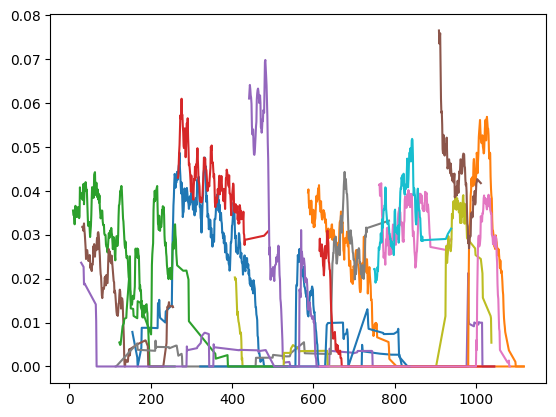

In [539]:
for i, v in new_df.value_counts('item').items():
    if v < 100:
        continue
    
    item_data = new_df[new_df.item==i]
    # series = item_data.clicks/item_data.recs
    series = item_data.clicks.rolling(10).sum() / item_data.recs.rolling(10).sum()
    plt.plot(item_data.time, series)